# Distributions

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

### Goals

In this noteboook we'll see three ways to describe a set of values:

* A probability mass function (PMF), which represents a set of values and the number of times each one appears in a dataset.

* A cumulative distribution function (CDF), which contains the same information as a PMF in a form that makes it easier to visualize, compare distributions, and perform some computations.

* A kernel density estimate (KDE), which is like a smooth, continuous version of a histogram.

We will also see ways to compare distributions and compare real data to a mathematical model.

For examples, we'll use data from the General Social Survey (GSS) to look at distributions of age and income, and to explore the relationship between income and education.

In [1]:
# Get the data file

import os

if not os.path.exists('gss.hdf5'):
    !wget https://github.com/AllenDowney/ElementsOfDataScience/raw/master/gss.hdf5

The following cell installs one of the libraries we will use in this notebook, `empiricaldist`.  The details are not important, but if you are curious:

* It uses the `sys` library to check whether this notebook is running on Colab.

* It uses `pip` to install the library.  `pip` is not part of the Python language; the `!` indicates that it is a "shell command".

If you are running in another Jupyter environment, you will have to make sure that this library is installed.

In [2]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

## Distributions

A distribution is a set of values and their corresponding probabilities.  For example, if you roll a six-sided die, there are six possible outcomes, the number 1 through 6, and they all have the same probability, 1/6.

We can represent the distribution of outcomes with a table, like this:

```
Value        Probability
1            1/6
2            1/6
3            1/6
4            1/6
5            1/6
6            1/6
```

More generally, there can be any number of values, the values can be any type, and the probabilities do not have to be equal.

In this notebook, we explore distributions of age, income, and other quantities.  We'll see two ways to represent distributions, PMFs and CDFs, and several ways to visualize them.

## The General Social Survey

In this notebook we'll work with a new dataset, the General Social Survey.

The General Social Survey, or GSS, has run annually since 1972; it surveys a representative sample of the adult population in the U.S. and asks questions about demographics and beliefs about social and political issues.

It is widely used by politicians, policy makers, and researchers, including me.

The GSS dataset contains hundreds of columns; I've selected just a few.  And I have already cleaned and validated them, so we just have to read the file, like this.

In [3]:
import pandas as pd

gss = pd.read_hdf('gss.hdf5', 'gss')

If you run `gss.head()`, you can see the first few rows.

In [4]:
# gss.size
gss.head()

,year,age,cohort,sex,race,educ,realinc,gunlaw,grass,wtssall
0,1972,26.0,1946.0,1,1,18.0,13537.0,2.0,NaN,0.8893
1,1972,38.0,1934.0,2,1,12.0,18951.0,1.0,NaN,0.4446
2,1972,57.0,1915.0,1,1,12.0,30458.0,1.0,NaN,1.3339
3,1972,61.0,1911.0,2,1,14.0,37226.0,1.0,NaN,0.8893
4,1972,59.0,1913.0,1,1,12.0,30458.0,2.0,NaN,0.8893


## Probability mass functions

To get started with this dataset, let's look at the distribution of `educ`, which records the number of years of education for each respondent.  First I'll select a column from the DataFrame.

In [5]:
educ = gss['educ']

We've already seen one way to visualize a distribution, a histogram.  Here's the histogram of education level.

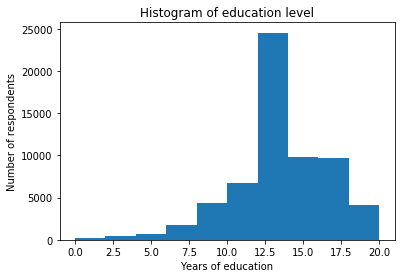

In [6]:
import matplotlib.pyplot as plt

plt.hist(educ.dropna())
plt.xlabel('Years of education')
plt.ylabel('Number of respondents')
plt.title('Histogram of education level');

Notice that we use `dropna` to drop NaNs from `educ` before we pass it to `hist`.

Based on the histogram, we can see the general shape of the distribution and the central tendency -- it looks like the peak is near 12 years of education.

But a histogram is not the best way to visualize this distribution.

An alternative is a "probability mass function", or PMF, that contains the unique values in the dataset and how often each one appears.

To represent a PMF, we'll use a library called `empiricaldist`, which provides a type called `Pmf`.  Notice the difference in capitalization: PMF is a mathematical concept, and `Pmf` is a type.

To import it, I'll use a version of the `import` statement we have not seen before.  The following statement imports only the `Pmf` type from the `empiricaldist` library.

In [7]:
# from empiricaldist import Pmf
from empyrical_dist import Pmf

`Pmf` provides a function called `from_seq` that takes any kind of sequence -- like a list, tuple, or Pandas Series -- and computes the PMF of the values in the sequence.

The result is a `Pmf` value, which is actually a specialized type of Pandas Series.

In [8]:
pmf_educ = Pmf.from_seq(educ, normalize=False)
type(pmf_educ)

empyrical_dist.empyrical_dist.Pmf

The keyword argument `normalize=False` indicates that we don't want to normalize this PMF.  I'll explain what that means soon.

Here's what the first and last few rows of the `Pmf` look like.

In [9]:
pmf_educ.head()

0.0    144
1.0     38
2.0    151
3.0    246
4.0    290
Name: educ, dtype: int64

In [10]:
pmf_educ.tail()

16.0    7953
17.0    1791
18.0    2109
19.0     774
20.0    1294
Name: educ, dtype: int64

The left column is the set of possible values; in this example it's the reported number of years of school.

The right column is the number of times each value appears in the sequences, which is the number of respondents who reported each value.

In this dataset, there are 7953 respondents who report that they have 16 years of formal education, which probably means they completed college.

You can use the bracket operator to look up a value in a Pmf and get the corresponding count:

In [11]:
pmf_educ[16]

7953

Usually when we make a PMF, we want to know the *fraction* of respondents with each value, rather than the counts.  We can do that by setting `normalize=True`; then we get a normalized PMF, that is, a PMF where the values in the second column add up to 1.

In [12]:
pmf_educ = Pmf.from_seq(educ, normalize=True)

pmf_educ.head()

0.0    0.002311
1.0    0.000610
2.0    0.002424
3.0    0.003948
4.0    0.004655
Name: educ, dtype: float64

Now if we use the bracket operator, the result is a fraction.  

For example, the fraction of people with 12 years of education is a little more than 30%:

In [13]:
pmf_educ[12]

0.3072836414997432

Each `Pmf` value provides a `.bar()` method that plots a PMF as a bar chart.

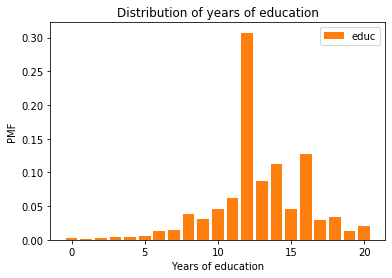

In [14]:
pmf_educ.bar(label='educ')

plt.xlabel('Years of education')
plt.ylabel('PMF')
plt.title('Distribution of years of education')
plt.legend();

In this figure, we can see that the most common value is 12 years, but there are also peaks at 14 and 16, which correspond to two and four years of college.

For this data, the PMF is probably a better choice than the histogram.  The PMF shows all unique values, so we can see where the peaks are.

Because the histogram puts values into bins, it obscures some details.  With this dataset, and the default number of bins, we couldn't see the peaks at 14 and 16 years.

PMFs have limitations, too, as we'll see.  But first, let's get some practice with PMFs.

**Exercise:** Let's look at another column in this DataFrame, `year`, which represents the year each respondent was interviewed.

Make an unnormalized PMF for `year` and display the result.
How many respondents were interviewed in 2016?

In [15]:
year = gss['year']
pmf_year = Pmf.from_seq(year, normalize=False)
pmf_year[2016]

2867

**Exercise:** Now let's plot a PMF for the age of the respondents in the GSS dataset.  The column `age` contains respondents' age in years.

Make a normalized PMF of `age` and plot it as a bar chart.

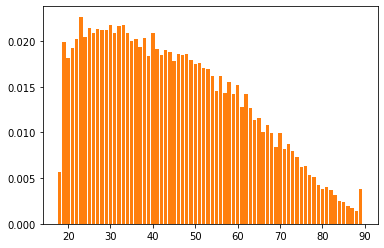

In [16]:
age = gss['age']
pmf_age = Pmf.from_seq(age, normalize=True)
pmf_age.bar()

## Cumulative distribution functions

Now we'll see another way to represent a distribution, the cumulative distribution function, or CDF.

CDFs are useful for some computations; they are also a great way to visualize and compare distributions.

A PMF tells you -- if you draw a random value from a distribution -- what's the chance of getting `x`, for any given value of `x`.

The CDF is similar; if you draw a random value from a distribution, it tells you the chance of getting a value less than or equal to `x`.

As an small example, suppose the distribution only has 5 elements: 1, 2, 2, 3, and 5.  The following table shows the PMF:

```
Value      Probability
1          1/5
2          2/5
3          1/5
5          1/5

```

The PMF says that the probability of value 1 is 1/5; the probability of value 2 is 2/5, and the probabilities for 3 and 5 are 1/5.

The CDF is the cumulative sum of the probabilities from the PMF, shown in the following table:

```
Value      Cumulative
           Probability
1          1/5
2          3/5
3          4/5
5          5/5

```

The CDF of 2 is three fifths, because three out of 5 values in the distribution are less than or equal to 2.

The CDF of 5 is 1, or 100%, because all of the values in the distribution are less than or equal to 5.

The `empiricaldist` library provides a `Cdf` type which is similar to the `Pmf` type we've seen, and we can import it the same way.

In [17]:
# from empiricaldist import Cdf
from empyrical_dist import Cdf

`Cdf` provides a function called `from_seq` that takes any kind of sequence and returns a new `Cdf` value.

The following example computes the CDF of ages for respondents in the General Social Survey.

In [18]:
cdf_age = Cdf.from_seq(gss['age'])

The result is a `Cdf` value we assign to `cdf_age`.

`cdf_age` has a method called `plot` that plots the CDF as a line.  Here's what it looks like.

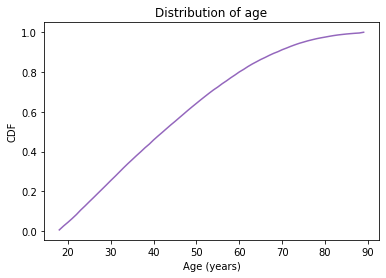

In [19]:
cdf_age.plot()

plt.xlabel('Age (years)')
plt.ylabel('CDF')
plt.title('Distribution of age');

The `x` axis is the ages, from 18 to 89.  The `y` axis is the cumulative probabilities, from 0 to 1.

`cdf_age` can be used as a function, so if you give it an age, it returns the corresponding probability (in a NumPy array).

In [20]:
q = 51
p = cdf_age(q)
p

array(0.66020135)

`q` stands for "quantity", which is what we are looking up.  `p` stands for probability, which is the result.

In this example, the quantity is age 51, and the corresponding probability is `p`, which is 0.66.

That means that about 66% of the respondents are 51 years old or younger.

The arrow in the following figure shows how you could read this value from the CDF, at least approximately.

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/cdf_forward.png)

The CDF is an invertible function, which means that if you have a probability, `p`, you can look up the corresponding quantity, `q`.

Here's how:


In [21]:
p = 0.25
q = cdf_age.inverse(p)
q

array(30.)

`cdf_age` has a method called `inverse` that computes the inverse of the cumulative distribution function.

In this example, we look up the probability 0.25, which returns 30.  

That means that 25% of the respondents are age 30 or less.  Another way to say the same thing is "age 30 is the 25th percentile of this distribution".

If we look up probability 0.75, it returns 57, so 75% of the respondents are 57 or younger.

In [22]:
p = 0.75
q = cdf_age.inverse(p)
q

array(57.)

In the following figure, the arrows show how you could read these values from the CDF.

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/cdf_inverse.png)

By the way, the distance from the 25th to the 75th percentile is called the "interquartile range", or IQR.  It measures the spread of the distribution, so it is similar to standard deviation or variance.

Because it is based on percentiles, it doesn't get thrown off by extreme values or outliers, the way standard deviation does.  So IQR is more "robust" than variance, which means it works well even if there are errors in the data or extreme values.

**Exercise:**  Using `cdf_age`, compute the fraction of the respondents in the GSS dataset that are OLDER than 65.

In [23]:
1-cdf_age(65)

0.13697596377707488

**Exercise:** The distribution of income in almost every country is long-tailed, which means there are a small number of people with very high incomes.

In the GSS dataset, the column `realinc` represents total household income, converted to 1986 dollars.  We can get a sense of the shape of this distribution by plotting the CDF.

Select `realinc` from the `gss` dataset, make a `Cdf` called `cdf_income`, and plot it.  Remember to label the axes!

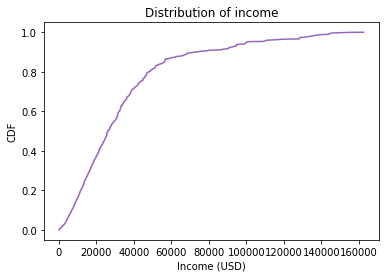

In [24]:
cdf_income = Cdf.from_seq(gss['realinc'])
cdf_income.plot()
plt.xlabel('Income (USD)')
plt.ylabel('CDF')
plt.title('Distribution of income');

In [25]:
cdf_income.inverse(0.25), cdf_income.inverse(0.5), cdf_income.inverse(0.75)

(array(13750.), array(26015.), array(43426.))

In [26]:
cdf_income(43426)-cdf_income(13750)

0.5002612659687562

## Comparing distributions

So far we've seen two ways to represent distributions, PMFs and CDFs.  Now we'll use PMFs and CDFs to compare distributions, and we'll see the pros and cons of each.

One way to compare distributions is to plot multiple PMFs on the same axes.  For example, suppose we want to compare the distribution of age for male and female respondents.

First I'll create a Boolean Series that's true for male respondents.

In [27]:
male = (gss['sex'] == 1)

And another that's true for female respondents.

In [28]:
female = (gss['sex'] == 2)

And I'll extract the `age` column.

In [29]:
age = gss['age']

Now I can select ages for the male and female respondents.

In [30]:
male_age = age[male]
female_age = age[female]

And plot a Pmf for each.

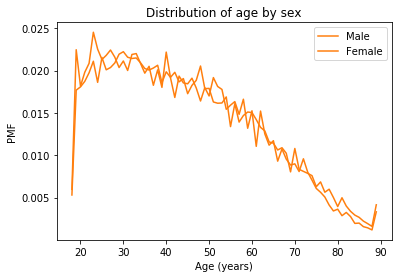

In [31]:
Pmf.from_seq(male_age).plot(label='Male')
Pmf.from_seq(female_age).plot(label='Female')

plt.xlabel('Age (years)') 
plt.ylabel('PMF')
plt.title('Distribution of age by sex')
plt.legend();

It looks like there are more men in their twenties, maybe.  And there are more women in their 70s and 80s.

In between, the plot is pretty noisy; most of these differences are just random variations.

Now let's do the same thing with CDFs; everything is the same except we replace `Pmf` with `Cdf`.

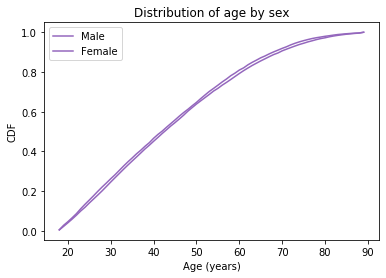

In [32]:
Cdf.from_seq(male_age).plot(label='Male')
Cdf.from_seq(female_age).plot(label='Female')

plt.xlabel('Age (years)') 
plt.ylabel('CDF')
plt.title('Distribution of age by sex')
plt.legend();

In general, CDFs are smoother than PMFs.  Because they smooth out randomness, we can often get a better view of real differences between distributions.

In this case, the lines are close together over the whole range; that is, the distributions are nearly identical.

But we can see the blue line to the left of the orange line across the distribution, which we can think of two ways:

* Suppose there is a club called the "Under 25 Club", where you have to be under 25 to get in.  A higher fraction of men would be able to get in, compared to the fraction of women.  But that doesn't necessarily mean there would be more men; that depends on the proportions of men and women in the population.

* Suppose there's another club called the "25th Percentile Club", where you have to be at or below the 25th percentile to get it.  The oldest eligible man would be a little younger than the oldest eligible woman.

In this example, the difference between the distibutions is consistent over the range of ages.  So everything we said about the "Under 25 Club" and the "25th Percentile Club" would also be true for 30, or the 30th percentile, or any other age or percentile.

## Income

As another example, let's look at household income and compare the distribution before and after 1995 (I chose 1995 because it's roughly the midpoint of the survey).

The variable `realinc` represents household income in 1986 dollars.

I'll make a Boolean Series to select respondents interviewed before and after 1995.

In [33]:
pre95 = (gss['year'] < 1995)
post95 = (gss['year'] >= 1995)

Now we can plot the PMFs.

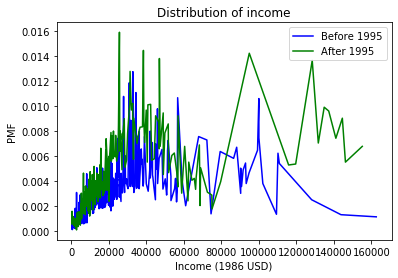

In [34]:
income = gss['realinc']

Pmf.from_seq(income[pre95]).plot(label='Before 1995', color='b')
Pmf.from_seq(income[post95]).plot(label='After 1995', color='g')

plt.xlabel('Income (1986 USD)')
plt.ylabel('PMF')
plt.title('Distribution of income')
plt.legend();

There are a lot of unique values in this distribution, and none of them appear very often.  As a result, the PMF is so noisy and we can't really see the shape of the distribution.

It's also hard to compare the distributions.
It looks like there are more people with high incomes after 1995, but it's hard to tell.  We can get a clearer picture with a CDF.

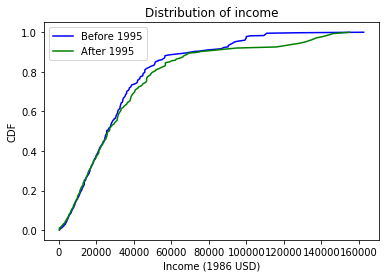

In [35]:
Cdf.from_seq(income[pre95]).plot(label='Before 1995', color='b')
Cdf.from_seq(income[post95]).plot(label='After 1995', color='g')

plt.xlabel('Income (1986 USD)')
plt.ylabel('CDF')
plt.title('Distribution of income')
plt.legend();

Below $30,000 the CDFs are almost identical; above that, we can see that the orange distribution is shifted to the right.

In other words, the fraction of people with high incomes is about the same, but the income of high earners has increased.

In general, I recommend CDFs for exploratory analysis.  They give you a clear view of the distribution, without too much noise, and they are good for comparing distributions, especially if you have more than two.

**Exercise:** In the previous figure, the dollar amounts are big enough that the labels on the `x` axis are crowded.  Improve the figure by expressing income in 1000s of dollars (and update the `x` label accordingly).

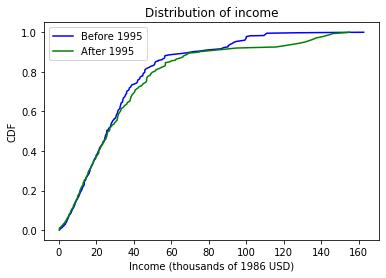

In [36]:
Cdf.from_seq(income[pre95]/1000).plot(label='Before 1995', color='b')
Cdf.from_seq(income[post95]/1000).plot(label='After 1995', color='g')

plt.xlabel('Income (thousands of 1986 USD)')
plt.ylabel('CDF')
plt.title('Distribution of income')
plt.legend();

**Exercise:** Let's compare incomes for different levels of education in the GSS dataset

To do that we'll create Boolean Series to identify respondents with different levels of education.

* In the U.S, 12 years of education usually means the respondent has completed high school (secondary education).  

* A respondent with 14 years of education has probably completed an associate degree (two years of college)

* Someone with 16 years has probably completed a bachelor's degree (four years of college).

Define Boolean Series named `high`, `assc`, and `bach` that are true for respondents with

* 12 or fewer years of education,

* 13, 14, or 15 years, and

* 16 or more.

Compute and plot the distribution of income for each group.  Remember to label the CDFs, display a legend, and label the axes.

Write a few sentences that describe and interpret the results.

In [37]:
high = gss['educ'] <= 12
assc = (gss['educ'] > 12) & (gss['educ'] < 16)
bach = gss['educ'] >= 16

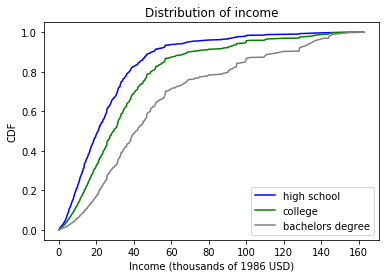

In [38]:
Cdf.from_seq(income[high]/1000).plot(label='high school', color='blue')
Cdf.from_seq(income[assc]/1000).plot(label='college', color='green')
Cdf.from_seq(income[bach]/1000).plot(label='bachelors degree', color='grey')
plt.title('Distribution of income')
plt.xlabel('Income (thousands of 1986 USD)')
plt.ylabel('CDF')
plt.legend()
plt.show()

## Modeling distributions

Some distributions have names.  For example, you have probably heard of the normal distribution, also called the Gaussian distribution.  And you might have heard of others like the exponential distribution, binomial distribution, or maybe Poisson distribution.

These "distributions with names" are called "analytic" because they are described by analytic mathematical functions, as contrasted with "empirical" distributions, which are based on data.

It turns out that many things we measure in the world have distributions that are well approximated by a analytic distributions, so these distributions are sometimes good models for the real world.  

In this context, what I mean by a "model" is a simplified description of the world that is accurate enough for its intended purpose.

In this section, you'll learn to compute the CDF of a normal distribution and compare it to an empirical distribution of data.


But before we work with real data, I'll start with some fake data, generated at random from an actual normal distribution.

In [39]:
import numpy as np

sample = np.random.normal(size=1000)

NumPy provides `random.normal`, which generates values from a normal distribution with mean 0 and standard deviation 1.

Here's what the empirical disrtribution of this fake data looks like.

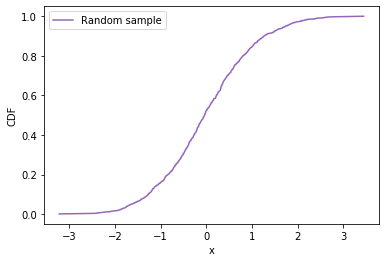

In [40]:
cdf_sample = Cdf.from_seq(sample)
cdf_sample.plot(label='Random sample')

plt.xlabel('x')
plt.ylabel('CDF')
plt.legend();

This sigmoid shape is what we expect to see with values from a normal distribution.

If we did not know that this sample was drawn from a normal distribution, and we wanted to check, we could compare the CDF of the data to the CDF of an ideal normal distribution, which we can use the SciPy library to compute.

In [41]:
from scipy.stats import norm

xs = np.linspace(-3, 3)
ys = norm(0, 1).cdf(xs)

First we import `norm` from `scipy.stats`, which is a collection of functions related to statistics.

Then we use `linspace()` to create an array of equally-spaced points from -3 to 3; those are the `x` values where we will evaluate the normal CDF.

Next, `norm(0, 1)` creates a value that represents a normal distribution with mean 0 and standard deviation 1.

Finally, `cdf()` computes the CDF of the normal distribution, evaluated at each of the `xs`.

I'll plot the normal CDF with a gray line and then plot the CDF of the data again.

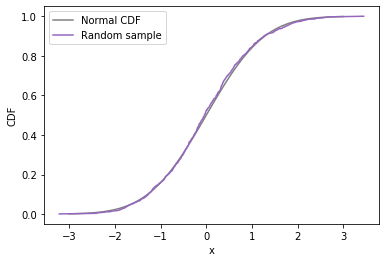

In [42]:
plt.plot(xs, ys, color='gray', label='Normal CDF')
cdf_sample.plot(label='Random sample')

plt.xlabel('x')
plt.ylabel('CDF')
plt.legend();

The CDF of the random sample agrees with the normal model, but that's not surprising because the data were actually sampled from a normal distribution.

When we collect data in the real world, we do not expect it to fit a normal distribution as well as this.  In the next exercise, we'll try it and see. 

**Exercise:** Is the normal distribution a good model for the distribution of ages in the U.S. population?

To answer this question:

* Compute the mean and standard deviation of ages in the GSS dataset.

* Use `linspace` to create an array of `x` values between 18 and 89.

* Use `norm` to create a normal distribution with the same mean and standard deviation as the data, then use it to compute the normal CDF for each `x` value.

* Plot the normal CDF with a gray line.

* Plot the CDF of the ages in the GSS.

How well do the plotted CDFs agree?

In [43]:
# 1.
mean = gss['age'].mean()
s = gss['age'].std()
mean, s

(44.6483197122718, 17.072243520474423)

In [44]:
# 2.
xs = np.linspace(18, 89)

# 3.
ys = norm(mean, s).cdf(xs)

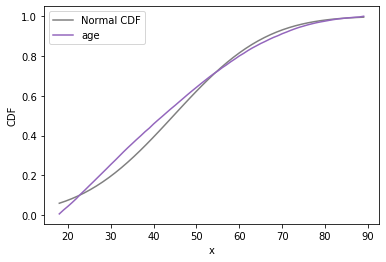

In [45]:
# 4.-5.
plt.plot(xs, ys, color='gray', label='Normal CDF')
Cdf.from_seq(gss['age']).plot()
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend();

In [46]:
# 6. Quite nicely.

**Exercise:** In many datasets, the distribution of income is approximately "lognormal", which means that the logarithms of the incomes fit a normal distribution.  We'll see whether that's true for the GSS data. 

* Extract `realinc` from `gss` and compute its logarithm using `np.log10()`.

* Compute the mean and standard deviation of the log-transformed incomes.

* Use `norm` to make a normal distribution with the same mean and standard deviation as the log-transformed incomes.

* Plot the CDF of the normal distribution.

* Compute and plot the CDF of the log-transformed incomes.

How similar are the CDFs of the log-transformed incomes and the normal distribution?

In [47]:
# 1.-2.  
mean = np.log10(gss['realinc']).mean()
s = np.log10(gss['realinc']).std()
lower, upper = np.log10(gss['realinc']).min(), np.log10(gss['realinc']).max()

In [48]:
# 3.
xs = np.linspace(lower, upper)
ys = norm(mean, s).cdf(xs)

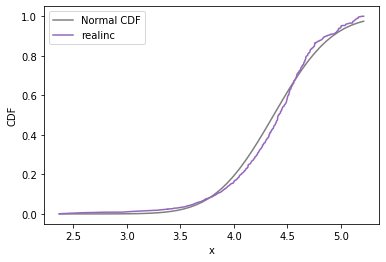

In [49]:
# 4.
plt.plot(xs, ys, color='gray', label='Normal CDF')
Cdf.from_seq(np.log10(gss['realinc'])).plot()
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend();

# 5. Quite similar

## Probability distribution functions

We have learned about two ways to represent distributions, PMFs and CDFs.  Now we'll learn another way: a probability density function, or PDF.  And we'll learn how to estimate PDFs from data.

`norm`, which we used to compute the normal CDF, can also compute the normal PDF:

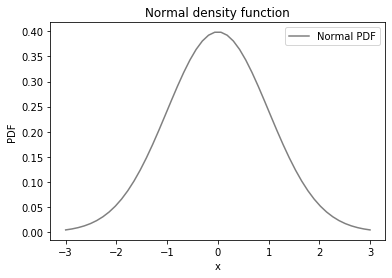

In [50]:
xs = np.linspace(-3, 3)
ys = norm(0,1).pdf(xs)
plt.plot(xs, ys, color='gray', label='Normal PDF')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

The normal PDF is the classic "bell curve".  

It is tempting to compare the PMF of the data to the PDF of the normal distribution, but that doesn't work.

Let's see what happens if we try:

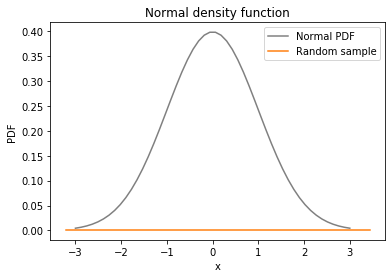

In [51]:
plt.plot(xs, ys, color='gray', label='Normal PDF')

pmf_sample = Pmf.from_seq(sample)
pmf_sample.plot(label='Random sample')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

The PMF of the sample is a flat line across the bottom.  In the random sample, every value is unique, so they all have the same probability, one in 1000.

However, we can use the points in the sample to estimate the PDF of the distribution they came from.

This process is called "kernel density estimation", or KDE.  It's a way of getting from a PMF, a probability mass function, to a PDF, a probability density function.

To generate a KDE plot, we'll use the Seaborn library, which I'll import as `sns`.

Seaborn provides `kdeplot`, which takes the sample, estimates the PDF, and plots it.

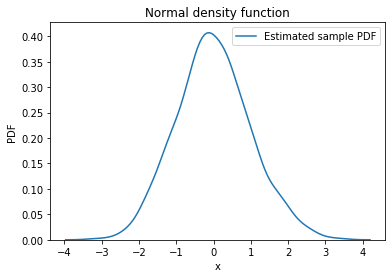

In [52]:
import seaborn as sns

sns.kdeplot(sample, label='Estimated sample PDF')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

Now we can compare the KDE plot and the normal PDF.

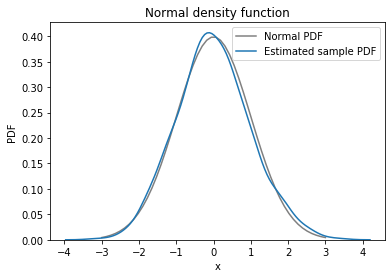

In [53]:
xs = np.linspace(-3, 3)
ys = norm.pdf(xs)
plt.plot(xs, ys, color='gray', label='Normal PDF')
sns.kdeplot(sample, label='Estimated sample PDF')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

The KDE plot matches the normal PDF pretty well, although the differences look bigger when we compare PDFs than they did with the CDFs.

On one hand, that means that the PDF is a more sensitive way to look for differences, but often it is too sensitive.  It's hard to tell whether apparent differences mean anything, or if they are just random, as in this case.

**Exercise:** In a previous exercise, we asked "Is the normal distribution a good model for the distribution of ages in the U.S. population?"  To answer this questions, we plotted the CDF of the data and compared it to the CDF of a normal distribution with the same mean and standard deviation.

Now we'll compare the estimated density of the data with the normal PDF.

* Again, compute the mean and standard deviation of ages in the GSS dataset.

* Use `linspace` to create an array of `x` values between 18 and 89.

* Use `norm` to create a normal distribution with the same mean and standard deviation as the data, then use it to compute the normal PDF for each `x` value.

* Plot the normal PDF with a gray line.

* Use `sns.kdeplot` to estimate and plot the density of the ages in the GSS.  

Note: Seaborn can't handle NaNs, so use `dropna` to drop them before calling `kdeplot`.

How well do the PDF and KDE plots agree?

In [54]:
# Solution goes here

**Exercise:** In the previous exercise, we used CDFs to see if the distribution of income is lognormal.  We can make the same comparison using a PDF and KDE.

* Again, extract `realinc` from `gss` and compute its logarithm using `np.log10()`.

* Compute the mean and standard deviation of the log-transformed incomes.

* Use `norm` to make a normal distribution with the same mean and standard deviation as the log-transformed incomes.

* Plot the PDF of the normal distribution.

* Use `sns.kdeplot()` to estimate and plot the density of the log-transformed incomes.

In [55]:
# Solution goes here

To summarize, we've seen three ways to visualize distributions, PMFs, CDFs, and KDE.

In general, I use CDFs when I am exploring data.  I think they give the best view of what's going on without getting distracted by noise.

The biggest drawback of CDFs is that they are less well known.  If I am presenting results to an audience unfamiliar with CDFs, I'll use a PMF for distributions with a small number of unique values and KDE if there are a lot of values.